In [1]:
import pickle
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
from scipy import misc
import scipy.misc

In [2]:
with open("classifier.pickle", "rb") as f:
    (svc, X_scaler) = pickle.load(f)

In [3]:
# These are the values used in the, svc, classifier
# performs under different binning scenarios
xy_overlap = (0.75, 0.75)
y_start_stop = [340, 680] # Min and max in y to search in slide_window()
x_start_stop = [760, 1260]
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
vis = True

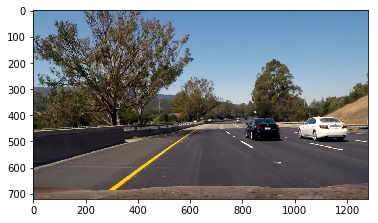

In [4]:

image = cv2.cvtColor(cv2.imread('CarND-Vehicle-Detection-master/test_images/test6.jpg'), cv2.COLOR_BGR2RGB)
normalized_image = image.astype(np.float32)/255
plt.imshow(normalized_image)

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=spatial_size):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel= hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat):


    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    #image = img.astype(np.float32)/255
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [12]:

draw_image = np.copy(normalized_image)


In [13]:
def slide_windows_cumulative(img):
    # create an empty list to append all windows
    all_windows = []
    for size in [64, 80, 96, 112, 128, 144]:
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(size, size), xy_overlap=xy_overlap)
        all_windows += windows
    return all_windows

In [14]:

windows = slide_windows_cumulative(normalized_image)

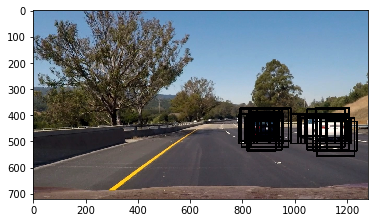

In [15]:
hot_windows = search_windows(normalized_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    


plt.imshow(window_img)

In [16]:
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
heat_threshold = 1

#all_bboxes are the hot_windows
def add_heat(heatmap, all_bboxes):
    # Iterate through list of bboxes
    for box in all_bboxes:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


#labels is a 2-tuple, where the first item is an array the size 
#of the heatmap input image and the second element is the number 
#of labels (cars) found.
from scipy.ndimage.measurements import label
heatmap = add_heat(heat, hot_windows)



2 cars found


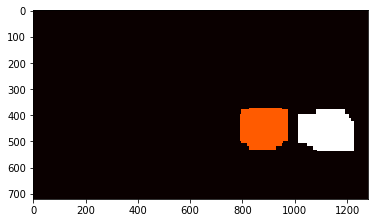

In [17]:
heatmap = apply_threshold(heatmap, heat_threshold)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='hot')

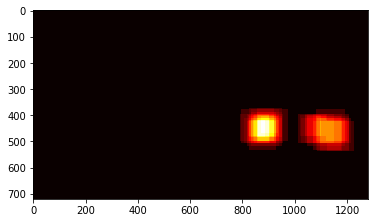

In [18]:
plt.imshow(heatmap, cmap='hot')

In [19]:
def show_images(images, per_row=2, titles=None, main_title=None):
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        if (titles is not None and len(titles) >= n):
            ax.set_title(titles[n])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

In [20]:
labels[1]

2

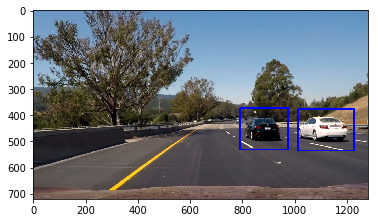

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

In [22]:
images_path = 'CarND-Advanced-Lane-Lines-master/SomeFrames/*.jpg'
image_files = glob.glob(images_path)

for fname in image_files:
     
    img = cv2.imread(fname)
    show_images([process_image(img)], titles=[fname])

In [23]:
normalized_image = image.astype(np.float32)/255
draw_image = np.copy(normalized_image)
windows = slide_windows_cumulative(normalized_image)
hot_windows = search_windows(normalized_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       



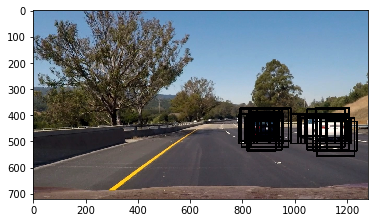

In [24]:
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
plt.imshow(window_img)

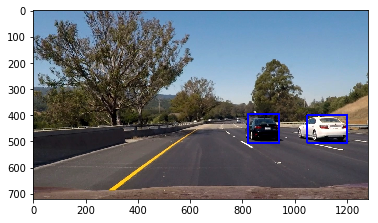

In [25]:
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
heat_threshold = 7
heatmap = add_heat(heat, hot_windows)
heatmap = apply_threshold(heatmap, heat_threshold)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    
    #return draw_img
plt.imshow(draw_img)

In [26]:
def process_image(image):
    normalized_image = image.astype(np.float32)/255
    draw_image = np.copy(normalized_image)
    windows = slide_windows_cumulative(normalized_image)
    hot_windows = search_windows(normalized_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    heat_threshold = 7
    heatmap = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heatmap, heat_threshold)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    
    #return draw_img
    return draw_img

In [27]:
def show_images(images, per_row=2, titles=None, main_title=None):
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        if (titles is not None and len(titles) >= n):
            ax.set_title(titles[n])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

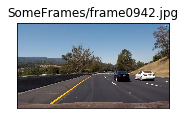

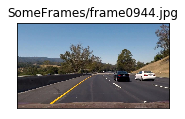

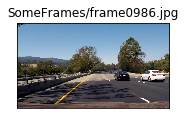

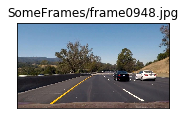

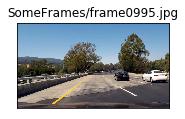

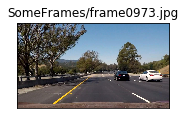

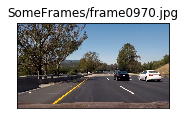

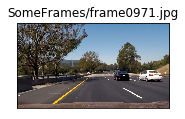

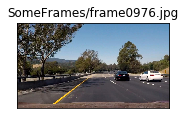

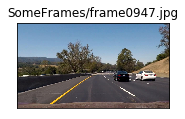

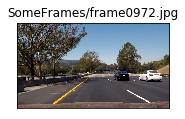

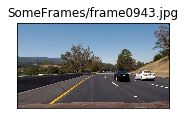

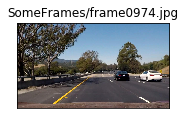

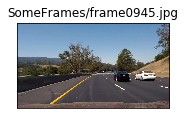

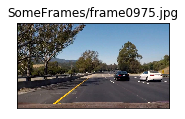

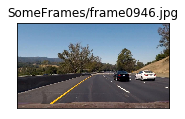

In [28]:
images_path = 'SomeFrames/*.jpg'
image_files = glob.glob(images_path)

for fname in image_files:
     
    img = cv2.imread(fname)
    show_images([process_image(img)], titles=[fname])

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
movie_output = 'movie.mp4'
clip1 = VideoFileClip("CarND-Vehicle-Detection-P5-master/test_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(movie_output, audio = False)


[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4


 97%|█████████▋| 38/39 [06:17<00:09,  9.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 

CPU times: user 6min 16s, sys: 168 ms, total: 6min 16s
Wall time: 6min 17s


/home/denise/anaconda3/envs/carnd-term1/bin/python /home/denise/p5/Searchclassify_20170216.py
Number of vehicles images found 8792
Number of non-vehicles images found 8968
got past Scaled_X
Using: 9 orientations 8 pixels per cell and 2 cells per block
color_space YCrCb
Feature vector length: 8460
55.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9916

In [30]:
Searchclassify_20170216

NameError: name 'Searchclassify_20170216' is not defined